<a href="https://colab.research.google.com/github/alouwyck/PhD/blob/main/chapter8_unconfined_flow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

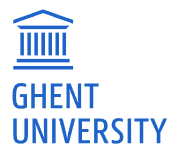<br>

**Axisymmetric Flow in Multilayer Aquifer Systems:**<br>
**Solutions and Theoretical Considerations**<br><br>
Andy Louwyck (2023)

---



---

# **CHAPTER 8: Modeling Unconfined Flow**

This Jupyter notebook implements the examples discussed in chapter 8 of my PhD thesis (Louwyck, 2023). The finite-difference simulations were done with [MAxSym](https://github.com/alouwyck/MAxSym) (Louwyck, 2011; Louwyck et al., 2012), and therefore, these simulations are not included here.

## Solutions

Import the required packages, modules, and functions.

In [1]:
import numpy as np
from numpy.linalg import multi_dot as mdot
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 100
import warnings
import scipy
from scipy.linalg import eig, inv, solve, LinAlgWarning, LinAlgError
from scipy.special import i0, k0, i1, k1, exp1
from math import factorial, log

Check versions:

In [2]:
print("NumPy", np.__version__)
print("Matplotlib", matplotlib.__version__)
print("SciPy", scipy.__version__)

NumPy 1.23.5
Matplotlib 3.7.1
SciPy 1.10.1


### Modified Bessel functions

Wrapper functions for the `scipy` modified Bessel functions:

In [45]:
def I0(x):
    # returns i0(x)
    y = i0(x)
    try:
        y[np.isnan(y)] = np.inf
    except TypeError:
        if np.isnan(y): y = np.inf
    return y

def K0(x):
    # returns k0(x)
    return k0(x)

def I1(x):
    # returns x * i1(x)
    x = np.array(x)
    y = x * i1(x)
    try:
        y[np.isnan(y)] = np.inf
    except TypeError:
        if np.isnan(y): y = np.inf
    return y

def K1(x):
    # returns x * k1(x)
    x = np.array(x)
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore', category=RuntimeWarning)  # suppress runtime warnings
        y = x * k1(x)
    b = np.isnan(y)
    if np.any(b):
        g = x > 1e10
        try:
            y[b & g] = 0.0
            y[b & ~g] = 1.0
        except TypeError:
            y = 0.0 if g else 1.0
    return y

### Stehfest algorithm

Function `stehfest` implements the Stehfest (1970) algorithm:

In [3]:
def stehfest(F, t, ns=12):
    """
    Stehfest algorithm for numerical inversion of Laplace transforms.

    Parameters
    ----------
    F : callable
      Function that calculates the Laplace transform. It has frequency parameter `p` [1/T] as input
      and returns the Laplace-transform `F(p)`. Input parameter `p` is a one-dimensional numpy array,
      and the returned output is also a one-dimensional numpy array with the same length as `p`.
    t : array_like
      One-dimensional array with the real times `t` [T].
    ns : int, default: 12
       Number of terms considered in the Stehfest algorithm applied for the inversion of the Laplace solution.
       Must be a positive, even integer.

    Returns
    -------
    f : ndarray
      One-dimensional array with the numerically inverted values `f(t)`. The length of `f` equals the length of `t`.
    """
    t = np.array(t)
    if t.ndim == 0:
        t = t[np.newaxis]
    nt = len(t)
    ns = int(ns)
    ln2t = log(2) / t
    W = stehfest_weights(ns)
    f = np.zeros(nt)
    for k in range(ns):
        p = ln2t * (k + 1)
        f += W[k] * F(p)
    return f * ln2t

def stehfest_weights(ns):
    """
    Calculate weights required for applying the Stehfest algorithm.

    Parameters
    ----------
    ns : int
       Number of terms considered in the Stehfest algorithm applied for the inversion of the Laplace solution.
       Must be a positive, even integer.

    Returns
    -------
    W : ndarray
      One-dimensional array with weights, length of `W` is equal to `ns`.
    """
    fac = lambda x: float(factorial(x))
    ns2 = ns // 2
    W = np.zeros(ns)
    for j in range(1, ns + 1):
        m = min(j, ns2)
        k_0 = (j + 1) // 2
        for k in range(k_0, m + 1):
            W[j - 1] += k ** ns2 * fac(2 * k) / fac(ns2 - k) / fac(k) / fac(k - 1) / fac(j - k) / fac(2 * k - j)
        W[j - 1] *= (-1) ** (ns2 + j)
    return W

### Dupuit

Function `Dupuit` implements the Dupuit (1857, 1863) formula for steady-state unconfined well-flow:

In [7]:
def dupuit(r, K, Q, r_out, h0):
    """
    Simulate steady flow to a pumping well fully penetrating an unconfined aquifer.

    Parameters
    ----------
    r : array_like
      One-dimensional array with the radial distances [L].
    K : float
      Aquifer conductivity [L/T].
    Q : float
      Pumping rate [L³/T] of the well.
    r_out : float
          Radial distance [L] of outer model boundary.
    h0 : float
      Constant head [L] at outer model boundary.

    Returns
    -------
    h : ndarray
      Head [L] at distances `r`. Length of `h` is `nr`, with `nr` the length of `r`.
    """
    return np.sqrt(h0**2 - Q / np.pi / K * np.log(r / r_out))

### Thiem

Function `thiem` implements the Thiem (1870, 1906) formula for steady-state confined well-flow:

In [6]:
def thiem(r, T, Q, r_out, h0):
    """
    Simulate steady flow to a pumping well fully penetrating a confined aquifer.

    Parameters
    ----------
    r : array_like
      One-dimensional array with the radial distances [L].
    T : float
      Aquifer transmissivity [L²/T].
    Q : float
      Pumping rate [L³/T] of the well.
    r_out : float
          Radial distance [L] of outer model boundary.
    h0 : float
      Constant head [L] at outer model boundary.

    Returns
    -------
    h : ndarray
      Head [L] at distances `r`. Length of `h` is `nr`, with `nr` the length of `r`.
    """
    return h0 - Q / 2 / np.pi / T * np.log(r / r_out)

### Theis

Function `theis` implements the solution for transient flow to a pumping well fully penetrating a confined aquifer (Theis, 1935):

In [8]:
def theis(r, t, T, S, Q):
    """
    Simulate transient flow to a pumping well fully penetrating a confined aquifer.

    Parameters
    ----------
    r : array_like
      One-dimensional array with the radial distances [L].
    t : array_like
      One-dimensional array with the simulation times [T].
    T : float
      Aquifer transmissivity [L²/T].
    S : float
      Aquifer storativity [-].
    Q : float
      Pumping rate [L³/T] of the well.

    Returns
    -------
    s : ndarray
      Drawdown [L] at distances `r` and times `t`.
      Shape of `s` is `(nr, nt)`, with `nr` the length of `r`, and `nt` the length of `t`.
    """
    t, r = np.meshgrid(t, r)
    return Q / 4 / np.pi / T * exp1(r**2 * S / 4 / t / T)

### Generalized semi-analytical solution

Class to simulate steady-state radial or parallel multilayer-multizone flow (Louwyck, 2023):

In [4]:
class Steady:
    """
    Class to simulate steady-state radial or parallel multilayer-multizone flow.

    Parameters
    ----------
    R : array_like
      Distances [L] of zone boundaries. The length of `R` is `nz+1` with `nz` the number of zones.
    T : array_like
      Transmissivities [L²/T]. The shape of `T` is `(nl, nz)` with `nl` the number of layers.
    c : array_like
      Vertical resistances [T]. The shape of `c` is `(nl+1, nz)`.
    Q : array_like, default: `None`
      Discharges [L³/T] at inner model boundary. The length of `Q` is `nl`.
    H : array_like, default: `None`
      Constant heads [L] at inner model boundary. The length of `H` is `nl`.
    N : array_like, default: `None`
      Recharge fluxes [L/T]. The shape of `N` is `(nl, nz)`.
    h0 : array_like, default: `None`
       Constant heads [L]. The shape of `h0` is `(nl+2, nz)`.
       Note that only `h0[0, :]`, `h0[-1, :]`, and `h0[:, -1]` are relevant for steady-state flow.
    axi : boolean, default: `True`
        Radial flow is simulated if `True`, parallel flow otherwise.

    Attributes
    ----------
    nl : int
       Number of layers
    nz : int
       Number of zones
    no_warnings : bool, default: `True`
                If `True`, the following warnings are suppressed: `RunTimeWarning` and SciPy `LinAlgWarning`.
    use_scipy_solver : bool, default is `True`
                     Indicates the solver that is applied to solve the system determining the integration constants.
                     If `True`, standard LU decomposition is applied implemented in SciPy.linalg function `solve`.
                     If `False`, a custom algorithm is applied similar to the Thomas algorithm.
    eps : float, default is `1e-16`
        Integration constants lower than `eps` are set to zero.

    Methods
    -------
    h(r) :
         Calculate hydraulic head h [L] at given distances r [L].
    qh(r) :
          Calculate radial or horizontal discharge Qh [L³/T] at given distances r [L].
    """

    def __init__(self, R, T, c, Q=None, H=None, N=None, h0=None, axi=True):
        self.R = np.array(R)
        self.T = np.array(T)
        self.c = np.array(c)
        self.Q = None if Q is None else np.array(Q)
        self.H = None if H is None else np.array(H)
        self.nl, self.nz = self.T.shape
        if N is None:
            self.N = np.zeros((self.nl, self.nz))
        else:
            self.N = np.array(N)
        if h0 is None:
            self.h0 = np.zeros((self.nl+2, self.nz))
        else:
            self.h0 = np.array(h0)
        self.axi = axi
        self.confined = np.all(np.isinf([self.c[0, :], self.c[-1, :]]), axis=0)
        self._initialized = False
        self.eps = 1e-16
        self.use_scipy_solver = True
        self.no_warnings = True

    def _ini_(self):
        if not self._initialized:
            self._Ab_()
            self._eig_()
            if self.axi:
                self._IKm_axi_()
                self._XYz_axi_()
            else:
                self._IKm_par_()
                self._XYz_par_()
            self._alpha_beta_()
            self._initialized = True

    def _Ab_(self):
        self._A = np.zeros((self.nz, self.nl, self.nl))  # (nz, nl, nl)
        self._b = np.zeros((self.nz, self.nl))  # (nz, nl)
        for k in range(self.nz):
            Tc0 = 1 / (self.T[:, k] * self.c[:-1, k])  # (nl, )
            Tc1 = 1 / (self.T[:, k] * self.c[1:, k])  # (nl, )
            self._idx = np.diag_indices(self.nl)
            irow, icol = self._idx
            A = np.zeros((self.nl, self.nl))  # (nl, nl)
            A[irow, icol] = Tc0 + Tc1
            A[irow[:-1], icol[:-1] + 1] = -Tc1[:-1]
            A[irow[:-1] + 1, icol[:-1]] = -Tc0[1:]
            self._A[k] = A
            b = self.N[:, k] / self.T[:, k]  # (nl, )
            b[0] += Tc0[0] * self.h0[0, k]
            b[-1] += Tc1[-1] * self.h0[-1, k]
            self._b[k] = b

    def _eig_(self):
        self._d = np.zeros((self.nz, self.nl))
        self._V = np.zeros((self.nz, self.nl, self.nl))
        self._iV = np.zeros((self.nz, self.nl, self.nl))
        self._v = np.zeros((self.nz, self.nl))
        self._inz = []
        self._iz = []
        self._sd = []
        for k in range(self.nz):
            d, V = eig(self._A[k])  # (nl, ), (nl, nl)
            d = np.real(d)
            inz = np.arange(self.nl)
            if self.confined[k]:
                iz = np.argmin(np.abs(d))
                inz = np.setdiff1d(inz, iz)
            else:
                iz = []
            if len(inz) > 0:
                sd = np.sqrt(d[inz])
            else:
                sd = []
            iV = inv(V)
            self._d[k] = d
            self._V[k] = V
            self._iV[k] = iV
            self._inz.append(inz)
            self._iz.append(iz)
            self._sd.append(sd)
            self._v[k] = np.dot(iV, self._b[k])

    def _IKm_axi_(self):
        self._I1 = np.zeros((self.nz, self.nl, self.nl))
        self._K1 = np.zeros((self.nz, self.nl, self.nl))
        self._m1 = np.zeros((self.nz, self.nl))
        self._I2 = np.zeros((self.nz, self.nl, self.nl))
        self._K2 = np.zeros((self.nz, self.nl, self.nl))
        self._m2 = np.zeros((self.nz, self.nl))
        for k in range(self.nz):
            I1, K1 = np.zeros(self.nl), np.zeros(self.nl)
            I2, K2 = np.zeros(self.nl), np.zeros(self.nl)
            if self.confined[k]:
                iz = self._iz[k]
                I1[iz], I2[iz] = np.log(self.R[k]), np.log(self.R[k+1])
                K1[iz], K2[iz] = 1.0, 1.0
                self._m1[k, iz] = -self._v[k][iz] * self.R[k]**2 / 4
                self._m2[k, iz] = -self._v[k][iz] * self.R[k+1]**2 / 4
            if len(self._inz[k]) > 0:
                inz = self._inz[k]
                x1, x2 = self.R[k] * self._sd[k], self.R[k+1] * self._sd[k]
                I1[inz], I2[inz] = i0(x1), i0(x2)
                I1[np.isnan(I1)] = np.inf  # i0(inf) = inf
                I2[np.isnan(I2)] = np.inf  # i0(inf) = inf
                K1[inz], K2[inz] = k0(x1), k0(x2)
                self._m1[k, inz] = self._m2[k, inz] = self._v[k][inz] / self._d[k][inz]
            self._I1[k], self._I2[k] = np.dot(self._V[k], np.diag(I1)), np.dot(self._V[k], np.diag(I2))
            self._K1[k], self._K2[k] = np.dot(self._V[k], np.diag(K1)), np.dot(self._V[k], np.diag(K2))
            self._m1[k], self._m2[k] = np.dot(self._V[k], self._m1[k]), np.dot(self._V[k], self._m2[k])

    def _IKm_par_(self):
        self._I1 = np.zeros((self.nz, self.nl, self.nl))
        self._K1 = np.zeros((self.nz, self.nl, self.nl))
        self._m1 = np.zeros((self.nz, self.nl))
        self._I2 = np.zeros((self.nz, self.nl, self.nl))
        self._K2 = np.zeros((self.nz, self.nl, self.nl))
        self._m2 = np.zeros((self.nz, self.nl))
        for k in range(self.nz):
            I1, K1 = np.zeros(self.nl), np.zeros(self.nl)
            I2, K2 = np.zeros(self.nl), np.zeros(self.nl)
            if self.confined[k]:
                iz = self._iz[k]
                I1[iz], I2[iz] = self.R[k], self.R[k+1]
                K1[iz], K2[iz] = 1.0, 1.0
                self._m1[k, iz] = -self._v[k][iz] * self.R[k]**2 / 2
                self._m2[k, iz] = -self._v[k][iz] * self.R[k+1]**2 / 2
            if len(self._inz[k]) > 0:
                inz = self._inz[k]
                x1, x2 = self.R[k] * self._sd[k], self.R[k+1] * self._sd[k]
                I1[inz], I2[inz] = np.exp(x1), np.exp(x2)
                K1[inz], K2[inz] = np.exp(-x1), np.exp(-x2)
                self._m1[k, inz] = self._m2[k, inz] = self._v[k][inz] / self._d[k][inz]
            self._I1[k], self._I2[k] = np.dot(self._V[k], np.diag(I1)), np.dot(self._V[k], np.diag(I2))
            self._K1[k], self._K2[k] = np.dot(self._V[k], np.diag(K1)), np.dot(self._V[k], np.diag(K2))
            self._m1[k], self._m2[k] = np.dot(self._V[k], self._m1[k]), np.dot(self._V[k], self._m2[k])

    def _XYz_axi_(self):
        self._X1 = np.zeros((self.nz, self.nl, self.nl))
        self._Y1 = np.zeros((self.nz, self.nl, self.nl))
        self._z1 = np.zeros((self.nz, self.nl))
        self._X2 = np.zeros((self.nz, self.nl, self.nl))
        self._Y2 = np.zeros((self.nz, self.nl, self.nl))
        self._z2 = np.zeros((self.nz, self.nl))
        for k in range(self.nz):
            TV = np.dot(np.diag(2 * np.pi * self.T[:, k]), self._V[k])
            X1, X2 = np.zeros(self.nl), np.zeros(self.nl)
            Y1, Y2 = np.zeros(self.nl), np.zeros(self.nl)
            if self.confined[k]:
                iz = self._iz[k]
                X1[iz], X2[iz] = 1.0, 1.0
                self._z1[k, iz] = -self._v[k][iz] * self.R[k]**2 / 2
                self._z2[k, iz] = -self._v[k][iz] * self.R[k+1]**2 / 2
            if len(self._inz[k]) > 0:
                inz = self._inz[k]
                x1, x2 = self.R[k] * self._sd[k], self.R[k+1] * self._sd[k]
                X1[inz], X2[inz] = x1 * i1(x1), x2 * i1(x2)
                X1[np.isnan(X1)] = np.inf  # inf*i1(inf) = inf
                X2[np.isnan(X2)] = np.inf  # inf*i1(inf) = inf
                Y1[inz], Y2[inz] = -x1 * k1(x1), -x2 * k1(x2)
                b1, b2 = np.isnan(Y1), np.isnan(Y2)
                if np.any(b1):
                    if np.all(x1[b1[inz]] < 1):
                        Y1[b1] = -1.0  # 0*k1(0) = 1
                    else:
                        Y1[b1] = 0.0  # inf*k1(inf) = 0
                if np.any(b2):
                    if np.all(x2[b2[inz]] < 1):
                        Y2[b2] = -1.0  # 0*k1(0) = 1
                    else:
                        Y2[b2] = 0.0  # inf*k1(inf) = 0
            self._X1[k], self._X2[k] = np.dot(TV, np.diag(X1)), np.dot(TV, np.diag(X2))
            self._Y1[k], self._Y2[k] = np.dot(TV, np.diag(Y1)), np.dot(TV, np.diag(Y2))
            self._z1[k], self._z2[k] = np.dot(TV, self._z1[k]), np.dot(TV, self._z2[k])

    def _XYz_par_(self):
        self._X1 = np.zeros((self.nz, self.nl, self.nl))
        self._Y1 = np.zeros((self.nz, self.nl, self.nl))
        self._z1 = np.zeros((self.nz, self.nl))
        self._X2 = np.zeros((self.nz, self.nl, self.nl))
        self._Y2 = np.zeros((self.nz, self.nl, self.nl))
        self._z2 = np.zeros((self.nz, self.nl))
        for k in range(self.nz):
            TV = np.dot(np.diag(self.T[:, k]), self._V[k])
            X1, X2 = np.zeros(self.nl), np.zeros(self.nl)
            Y1, Y2 = np.zeros(self.nl), np.zeros(self.nl)
            if self.confined[k]:
                iz = self._iz[k]
                X1[iz], X2[iz] = 1.0, 1.0
                self._z1[k, iz] = -self._v[k][iz] * self.R[k]
                self._z2[k, iz] = -self._v[k][iz] * self.R[k+1]
            if len(self._inz[k]) > 0:
                inz = self._inz[k]
                x1, x2 = self.R[k] * self._sd[k], self.R[k+1] * self._sd[k]
                X1[inz], X2[inz] = self._sd[k] * np.exp(x1), self._sd[k] * np.exp(x2)
                Y1[inz], Y2[inz] = -self._sd[k] * np.exp(-x1), -self._sd[k] * np.exp(-x2)
            self._X1[k], self._X2[k] = np.dot(TV, np.diag(X1)), np.dot(TV, np.diag(X2))
            self._Y1[k], self._Y2[k] = np.dot(TV, np.diag(Y1)), np.dot(TV, np.diag(Y2))
            self._z1[k], self._z2[k] = np.dot(TV, self._z1[k]), np.dot(TV, self._z2[k])

    def _alpha_beta_(self):
        self._alpha = np.zeros((self.nz, self.nl))
        self._beta = np.zeros((self.nz, self.nl))
        if self.use_scipy_solver:
            ab = self.__scipy_solver__()
            i = np.arange(0, 2) * self.nl
            for k in range(self.nz):
                self._beta[k] = ab[i[0]:i[1]]
                i += self.nl
                self._alpha[k] = ab[i[0]:i[1]]
                i += self.nl
            self._alpha[(np.abs(self._alpha) < self.eps) | np.isnan(self._alpha)] = 0.0
            self._beta[(np.abs(self._beta) < self.eps) | np.isnan(self._beta)] = 0.0
        else:
            self.__solver__()

    def __solver__(self):
        '''apply custom algorithm to find alpha and beta'''
        # check infinite values at boundaries between zones
        nz = 0
        stop = False
        while (nz < self.nz) and not stop:
            stop = np.any(np.isinf(self._I1[nz]) | np.isinf(self._X1[nz])) & \
                   np.any(np.isinf(self._I2[nz]) | np.isinf(self._X2[nz]))
            if not stop: nz += 1
        # forward
        ini = lambda: [[] for _ in range(nz)]
        F, G, H, dG, dH = ini(), ini(), ini(), ini(), ini()
        if self.Q is not None:
            A = inv(self._Y1[0], check_finite=False)
            dG[0] = np.dot(A, self._X1[0])
            dH[0] = -np.dot(A, self._z1[0] + self.Q)
        else:
            A = inv(self._K1[0], check_finite=False)
            dG[0] = np.dot(A, self._I1[0])
            dH[0] = -np.dot(A, self._m1[0] - self.H)
        for k in range(nz - 1):
            j = k + 1
            A = inv(self._K2[k], check_finite=False)
            L = inv(np.dot(A, self._I2[k]) - dG[k], check_finite=False)
            F[k] = -mdot((L, A, self._K1[j]))
            G[k] = -mdot((L, A, self._I1[j]))
            H[k] = np.dot(L, np.dot(A, self._m1[j] - self._m2[k]) - dH[k])
            A = inv(self._Y2[k], check_finite=False)
            dL = inv(np.dot(A, self._X2[k]) - dG[k], check_finite=False)
            dF = inv(-mdot((dL, A, self._Y1[j])) - F[k], check_finite=False)
            dG[j] = -np.dot(dF, mdot((dL, A, self._X1[j])) + G[k])
            dH[j] = np.dot(dF, np.dot(dL, np.dot(A, self._z1[j] - self._z2[k]) - dH[k]) - H[k])
        k = nz - 1
        try:
            A = inv(self._K2[k], check_finite=False)  # not invertible if R[nz] -> inf
            L = inv(np.dot(A, self._I2[k]) - dG[k], check_finite=False)
            H[k] = np.dot(L, np.dot(A, (self.h0[1:-1, k] - self._m2[k])) - dH[k])
        except LinAlgError:
            H[k] = np.zeros(self.nl)
        # backward
        self._alpha[k] = H[k]
        self._alpha[k][np.isnan(self._alpha[k])] = 0.0
        for k in range(nz - 2, -1, -1):
            j = k + 1
            self._beta[j] = dH[j] - np.dot(dG[j], self._alpha[j])
            self._beta[k][np.isnan(self._beta[k])] = 0.0
            self._alpha[k] = H[k] - np.dot(F[k], self._beta[j]) - np.dot(G[k], self._alpha[j])
            self._alpha[k][np.isnan(self._alpha[k])] = 0.0
        self._beta[0] = dH[0] - np.dot(dG[0], self._alpha[0])
        self._beta[0][np.isnan(self._beta[0])] = 0.0

    def __scipy_solver__(self):
        '''apply scipy solve function to find alpha and beta'''
        n = 2 * self.nl * self.nz
        M = np.zeros((n, n))
        rhs = np.zeros(n)
        # k = 0
        i = np.arange(0, 2) * self.nl
        j = np.arange(-2, 3) * self.nl
        if self.Q is not None:
            M[i[0]:i[1], j[2]:j[3]] = -self._Y1[0]
            M[i[0]:i[1], j[3]:j[4]] = -self._X1[0]
            rhs[i[0]:i[1]] = self._z1[0] + self.Q
        else:
            M[i[0]:i[1], j[2]:j[3]] = -self._K1[0]
            M[i[0]:i[1], j[3]:j[4]] = -self._I1[0]
            rhs[i[0]:i[1]] = self._m1[0] - self.H
        # 0 < k < nz-1
        for k in range(1, self.nz):
            i += self.nl
            j += 2 * self.nl
            M[i[0]:i[1], j[0]:j[1]] = self._K2[k-1]
            M[i[0]:i[1], j[1]:j[2]] = self._I2[k-1]
            M[i[0]:i[1], j[2]:j[3]] = -self._K1[k]
            M[i[0]:i[1], j[3]:j[4]] = -self._I1[k]
            rhs[i[0]:i[1]] = self._m1[k] - self._m2[k-1]
            i += self.nl
            M[i[0]:i[1], j[0]:j[1]] = self._Y2[k-1]
            M[i[0]:i[1], j[1]:j[2]] = self._X2[k-1]
            M[i[0]:i[1], j[2]:j[3]] = -self._Y1[k]
            M[i[0]:i[1], j[3]:j[4]] = -self._X1[k]
            rhs[i[0]:i[1]] = self._z1[k] - self._z2[k-1]
        # k = nz - 1
        k = self.nz - 1
        i += self.nl
        M[i[0]:i[1], j[2]:j[3]] = self._K2[k]
        M[i[0]:i[1], j[3]:j[4]] = self._I2[k]
        rhs[i[0]:i[1]] = self.h0[1:-1, k] - self._m2[k]
        self._M3, self._rhs3, self._until = self.__check_M__(M.copy(), rhs.copy())
        ab = np.zeros(len(rhs))
        ab[:self._until] = solve(self._M3, self._rhs3, check_finite=False)
        self._M, self._rhs = M.copy(), rhs.copy()
        M, rhs = self.__check_inf__(M, rhs)
        M, rhs = self.__check_zero_columns__(M, rhs)
        self._M2, self._rhs2 = M, rhs
        return ab

    def __check_M__(self, M, rhs):
        # check inf
        b = np.isinf(M)
        if np.any(b):
            irow, icol = np.where(b)
            until = np.min([np.min(irow), np.min(icol)])
            return M[:until, :until], rhs[:until], until
        else:
            return M, rhs, None

    def __check_zero_columns__(self, M, rhs):
        for i in np.where(np.all(M == 0, axis=0)):
            M[i, :] = 0
            M[i, i] = 1
            rhs[i] = 0
        return M, rhs

    def __check_inf__(self, M, rhs):
        b = np.any(np.isinf(M), axis=0)
        if np.any(b):
            i = np.min(np.where(b))
            M[i:, :] = 0
            M[i:, i:] = np.eye(len(M) - i)
            M[:i, i:] = 0
            rhs[i:] = 0
        return M, rhs

    def h(self, r):
        with warnings.catch_warnings():
            if self.no_warnings:
                warnings.filterwarnings('ignore', category=LinAlgWarning)  # suppress scipy.linalg warnings
                warnings.filterwarnings('ignore', category=RuntimeWarning)  # suppress runtime warnings
            self._ini_()
            r = np.array(r)
            nr = len(r)
            h = np.zeros((self.nl, nr))
            for j in range(nr):
                k = np.where((self.R[:-1] <= r[j]) & (r[j] <= self.R[1:]))[0][0]
                I, K, m = np.zeros(self.nl), np.zeros(self.nl), np.zeros(self.nl)
                if self.confined[k]:
                    iz = self._iz[k]
                    if self.axi:
                        I[iz], K[iz], m[iz] = np.log(r[j]), 1.0, -self._v[k][iz] * r[j]**2 / 4
                    else:
                        I[iz], K[iz], m[iz] = r[j], 1.0, -self._v[k][iz] * r[j]**2 / 2
                if len(self._inz[k]) > 0:
                    inz = self._inz[k]
                    x = r[j] * self._sd[k]
                    inz = self._inz[k]
                    if self.axi:
                        I[inz], K[inz], m[inz] = i0(x), k0(x), self._v[k][inz] / self._d[k][inz]
                    else:
                        I[inz], K[inz], m[inz] = np.exp(x), np.exp(-x), self._v[k][inz] / self._d[k][inz]
                Ia = I * self._alpha[k]
                Ia[np.isnan(Ia) | np.isinf(Ia)] = 0.0  # if alpha = 0 and I0 = Inf
                g = Ia + K * self._beta[k] + m
                h[:, j] = np.dot(self._V[k], g)
            return h

    def qr(self, r):
        with warnings.catch_warnings():
            if self.no_warnings:
                warnings.filterwarnings('ignore', category=LinAlgWarning)  # suppress scipy.linalg warnings
                warnings.filterwarnings('ignore', category=RuntimeWarning)  # suppress runtime warnings
            self._ini_()
            r = np.array(r)
            nr = len(r)
            qr = np.zeros((self.nl, nr))
            for j in range(nr):
                k = np.where((self.R[:-1] <= r[j]) & (r[j] <= self.R[1:]))[0][0]
                I, K, m = np.zeros(self.nl), np.zeros(self.nl), np.zeros(self.nl)
                if self.confined[k]:
                    iz = self._iz[k]
                    if self.axi:
                        I[iz], m[iz] = 1.0, -self._v[k][iz] * r[j]**2 / 2
                    else:
                        I[iz], m[iz] = 1.0, -self._v[k][iz] * r[j]
                if len(self._inz[k]) > 0:
                    inz = self._inz[k]
                    x = r[j] * self._sd[k]
                    inz = self._inz[k]
                    if self.axi:
                        I[inz], K[inz] = x * i1(x), -x * k1(x)
                        K[np.isnan(K)] = 1.0  # r -> 0: x_in * k1(x_in) = 1
                    else:
                        I[inz], K[inz] = self._sd[k] * np.exp(x), -self._sd[k] * np.exp(-x)
                Ia = I * self._alpha[k]
                Ia[np.isnan(Ia) | np.isinf(Ia)] = 0.0  # if alpha = 0 and I1 = Inf
                dg = Ia + K * self._beta[k] + m
                TV = np.dot(np.diag(2 * np.pi * self.T[:, k]), self._V[k])
                qr[:, j] = np.dot(TV, dg)
            return qr

Class to simulate transient-state radial or parallel multilayer-multizone flow (Louwyck, 2023):

In [5]:
class Transient:
    """
    Class to simulate transient-state radial or parallel multilayer-multizone flow.
    The Stehfest algorithm is applied to numerically invert the Laplace transform.

    Parameters
    ----------
    R : array_like
      Distances [L] of zone boundaries. The length of `R` is `nz+1` with `nz` the number of zones.
    T : array_like
      Transmissivities [L²/T]. The shape of `T` is `(nl, nz)` with `nl` the number of layers.
    S : array_like
      Storativities [-]. The shape of `S` is `(nl, nz)`.
    c : array_like
      Vertical resistances [T]. The shape of `c` is `(nl+1, nz)`.
    Q : array_like, default: `None`
      Discharges [L³/T] at inner model boundary. The length of `Q` is `nl`.
    H : array_like, default: `None`
      Constant heads [L] at inner model boundary. The length of `H` is `nl`.
    N : array_like, default: `None`
      Recharge fluxes [L/T]. The shape of `N` is `(nl, nz)`.
    h0 : array_like, default: `None`
       Initial heads [L]. The shape of `h0` is `(nl+2, nz)`.
    axi : boolean, default: `True`
        Radial flow is simulated if `True`, parallel flow otherwise.
    ns : int, default: `12`
       Number of Stehfest parameters

    Attributes
    ----------
    nl : int
       Number of layers
    nz : int
       Number of zones
    no_warnings : bool, default: `True`
                If `True`, the following warnings are suppressed: `RunTimeWarning` and SciPy `LinAlgWarning`.
    use_scipy_solver : bool, default is `True`
                     Indicates the solver that is applied to solve the system determining the integration constants.
                     If `True`, standard LU decomposition is applied implemented in SciPy.linalg function `solve`.
                     If `False`, a custom algorithm is applied similar to the Thomas algorithm.
    eps : float, default is `1e-16`
        Integration constants lower than `eps` are set to zero.

    Methods
    -------
    h(r, t) :
            Calculate hydraulic head h [L] at given distances r [L] and times [T].
    qh(r, t) :
             Calculate radial or horizontal discharge Qh [L³/T] at given distances r [L] and times [T].
    """

    def __init__(self, R, T, S, c, Q=None, H=None, N=None, h0=None, axi=True, ns=12):
        self.R = np.array(R)
        self.T = np.array(T)
        self.S = np.array(S)
        self.c = np.array(c)
        self.Q = None if Q is None else np.array(Q)
        self.H = None if H is None else np.array(H)
        self.nl, self.nz = self.T.shape
        if N is None:
            self.N = np.zeros((self.nl, self.nz))
        else:
            self.N = np.array(N)
        if h0 is None:
            self.h0 = np.zeros((self.nl+2, self.nz))
        else:
            self.h0 = np.array(h0)
        self.confined = np.all(np.isinf([self.c[0, :], self.c[-1, :]]), axis=0)
        self.axi = axi
        self.ns = int(ns)
        self._W = stehfest_weights(self.ns)
        self.use_scipy_solver = True
        self.eps = 1e-16
        self.no_warnings = True

    def h(self, r, t):
        with warnings.catch_warnings():
            if self.no_warnings:
                warnings.filterwarnings('ignore', category=LinAlgWarning)  # suppress scipy.linalg warnings
                warnings.filterwarnings('ignore', category=RuntimeWarning)  # suppress runtime warnings
            h = np.zeros((self.nl, len(r), len(t)))
            for i in range(len(t)):
                ln2t = np.log(2) / t[i]
                for j in range(self.ns):
                    p = ln2t * (j + 1)
                    if self.Q is not None:
                        m = Steady(self.R, self.T, self.c, Q=self.Q/p, N=self.N/p, h0=self.h0/p, axi=self.axi)
                    else:
                        m = Steady(self.R, self.T, self.c, H=self.H/p, N=self.N/p, h0=self.h0/p, axi=self.axi)
                    self._steady = m
                    m.eps = self.eps
                    m.no_warnings = self.no_warnings
                    m.use_scipy_solver = self.use_scipy_solver
                    m.confined = np.zeros(self.nz, dtype=bool)
                    m._Ab_()
                    for k in range(m.nz):
                        ST = self.S[:, k] / self.T[:, k]
                        m._A[k][m._idx] += ST * p
                        m._b[k] += ST * self.h0[1:-1, k]
                    m._eig_()
                    if self.axi:
                        m._IKm_axi_()
                        m._XYz_axi_()
                    else:
                        m._IKm_par_()
                        m._XYz_par_()
                    m._alpha_beta_()
                    m._initialized = True
                    h[:, :, i] += self._W[j] * m.h(r)
                h[:, :, i] *= ln2t
            return h

    def qr(self, r, t):
        with warnings.catch_warnings():
            if self.no_warnings:
                warnings.filterwarnings('ignore', category=LinAlgWarning)  # suppress scipy.linalg warnings
                warnings.filterwarnings('ignore', category=RuntimeWarning)  # suppress runtime warnings
            qr = np.zeros((self.nl, len(r), len(t)))
            for i in range(len(t)):
                ln2t = np.log(2) / t[i]
                for j in range(self.ns):
                    p = ln2t * (j + 1)
                    if self.Q is not None:
                        m = Steady(self.R, self.T, self.c, Q=self.Q/p, N=self.N/p, h0=self.h0/p, axi=self.axi)
                    else:
                        m = Steady(self.R, self.T, self.c, H=self.H/p, N=self.N/p, h0=self.h0/p, axi=self.axi)
                    self._steady = m
                    m.eps = self.eps
                    m.no_warnings = self.no_warnings
                    m.use_scipy_solver = self.use_scipy_solver
                    m.confined = np.zeros(self.nz, dtype=bool)
                    m._Ab_()
                    for k in range(m.nz):
                        ST = self.S[:, k] / self.T[:, k]
                        m._A[k][m._idx] += ST * p
                        m._b[k] += ST * self.h0[1:-1, k]
                    m._eig_()
                    if self.axi:
                        m._IKm_axi_()
                        m._XYz_axi_()
                    else:
                        m._IKm_par_()
                        m._XYz_par_()
                    m._alpha_beta_()
                    m._initialized = True
                    qr[:, :, i] += self._W[j] * m.qr(r)
                qr[:, :, i] *= ln2t
            return qr

### Multilayer Boulton

Class to simulate steady-state radial multilayer flow (Louwyck, 2023).

In [42]:
class OneZoneSteady:
    """
    Class to simulate steady two-dimensional radial flow in a multilayer aquifer system.

    Parameters
    ----------
    R : array_like
      Radial distance [L] of inner and outer model boundary, so R = [r_in, r_out]
    T : array_like
      Layer transmissivities [L²/T]. The length of `T` is `nl`, the number of layers.
    c : array_like
      Vertical resistances [T] between layers. The length of `c` is `nl+1`.
    Q : array_like
      Discharges [L³/T] at inner model boundary. The length of `Q` is `nl`.
    N : array_like, default: `None`
      Recharge flux [L/T] for each layer. The length of `N` is `nl`.
      By default, the recharge in each layer is zero.
    h_out : array_like, default: `None`
          Constant head [L] at the outer model boundary for each layer. The length of `h_out` is `nl+2`.
          By default, the constant heads at the outer boundary are zero.
    no_warnings : bool, default: True
                If `True`, the following warnings are suppressed: `RunTimeWarning` and SciPy `LinAlgWarning`.

    Attributes
    ----------
    nl : int
       Number of layers

    Methods
    -------
    h(r) :
         Calculate hydraulic head h [L] at given distances r [L].
    qr(r) :
          Calculate radial discharge Qr [L³/T] at given distances r [L].
    """
    def __init__(self, R, T, c, Q, N=None, h_out=None, no_warnings=True):
        self.R = np.array(R, dtype=float)  # [r_in, r_out]
        self.T = np.array(T, dtype=float)  # (nl,)
        self.c = np.array(c, dtype=float)  # (nl+1,)
        self.Q = np.array(Q, dtype=float)  # (nl,)
        self.nl = len(self.T)
        self.N = np.zeros(self.nl, dtype=float) if N is None else np.array(N, dtype=float)  # (nl,)
        self.h_out = np.zeros(self.nl+2, dtype=float) if h_out is None else np.array(h_out, dtype=float)  # (nl+2,)
        self.confined = np.all(np.isinf([self.c[0], self.c[-1]]))
        self._initialized = False
        self.no_warnings = no_warnings

    def _ini_(self):
        if not self._initialized:
            self._Ab_()
            self._eig_()
            self._alpha_beta_()
            self._initialized = True

    def _Ab_(self):
        Tc0 = 1 / (self.T * self.c[:-1])  # (nl,)
        Tc1 = 1 / (self.T * self.c[1:])  # (nl,)
        self._idx = np.diag_indices(self.nl)
        irow, icol = self._idx
        self._A = np.zeros((self.nl, self.nl))  # (nl, nl)
        self._A[irow, icol] = Tc0 + Tc1
        self._A[irow[:-1], icol[:-1] + 1] = -Tc1[:-1]
        self._A[irow[:-1] + 1, icol[:-1]] = -Tc0[1:]
        self._b = self.N / self.T  # (nl,)
        self._b[0] += Tc0[0] * self.h_out[0]
        self._b[-1] += Tc1[-1] * self.h_out[-1]

    def _eig_(self):
        self._d, self._V = eig(self._A)  # (nl,), (nl, nl)
        self._d = np.real(self._d)
        self._inz = np.arange(self.nl)  # (nl,)
        if self.confined:
            self._iz = np.argmin(np.abs(self._d))  # scalar
            self._inz = np.setdiff1d(self._inz, self._iz)  # (nl-1,)
        else:
            self._iz = []
        if len(self._inz) > 0:
            self._sd = np.sqrt(self._d[self._inz])  # (nl,)
        else:
            self._sd = []
        self._iV = inv(self._V)  # (nl, nl)
        self._v = np.dot(self._iV, self._b)  # (nl,)
        self._T = 2 * np.pi * self.T  # (nl,)
        self._q = np.dot(self._iV, self.Q / self._T)  # (nl,)
        self._u = np.dot(self._iV, self.h_out[1:-1])  # (nl,)

    def _IKm_(self, r):
        I = np.zeros(self.nl)  # (nl,)
        K = np.zeros(self.nl)  # (nl,)
        m = np.zeros(self.nl)  # (nl,)
        if self.confined:
            I[self._iz] = np.log(r)
            K[self._iz] = 1.0
            m[self._iz] = -self._v[self._iz] * r**2 / 4
        if len(self._inz) > 0:
            I[self._inz] = I0(r * self._sd)
            K[self._inz] = K0(r * self._sd)
            m[self._inz] = self._v[self._inz] / self._d[self._inz]
        return I, K, m  # (nl,), (nl,), (nl,)

    def _dIKm_(self, r):
        dI = np.zeros(self.nl)  # (nl,)
        dK = np.zeros(self.nl)  # (nl,)
        dm = np.zeros(self.nl)  # (nl,)
        if self.confined:
            dI[self._iz] = 1.0
            dm[self._iz] = -self._v[self._iz] * r**2 / 2
        if len(self._inz) > 0:
            dI[self._inz] = I1(r * self._sd)
            dK[self._inz] = -K1(r * self._sd)
        return dI, dK, dm  # (nl,), (nl,), (nl,)

    def _alpha_beta_(self):
        dI, dK, dm = self._dIKm_(self.R[0])  # (nl,), (nl,), (nl,)
        I, K, m = self._IKm_(self.R[-1])  # (nl,), (nl,), (nl,)
        self._X = K * dI - I * dK  # (nl,)
        q, u = self._q + dm, self._u - m  # (nl,), (nl,)
        self._alpha = (K * q + dK * u) / -self._X  # (nl,)
        self._beta = (I * q + dI * u) / self._X  # (nl,)
        b = np.isnan(self._beta)
        if np.any(b): self._beta[b] = (q[b] + dI[b] * u[b]) / -dK[b]  # (nl,)

    def h(self, r):
        r = np.array(r, dtype=float)
        if r.ndim == 0: r = r[np.newaxis]
        nr = len(r)
        h = np.zeros((self.nl, nr))
        with warnings.catch_warnings():
            if self.no_warnings:
                warnings.filterwarnings('ignore', category=LinAlgWarning)  # suppress scipy.linalg warnings
                warnings.filterwarnings('ignore', category=RuntimeWarning)  # suppress runtime warnings
            self._ini_()
            for j in range(nr):
                I, K, m = self._IKm_(r[j])
                Ia = I * self._alpha
                Ia[np.isnan(Ia) | np.isinf(Ia)] = 0.0  # if alpha = 0 and I0 = Inf
                h[:, j] = np.dot(self._V, Ia + K * self._beta + m)
        return h

    def qr(self, r):
        r = np.array(r, dtype=float)
        if r.ndim == 0: r = r[np.newaxis]
        nr = len(r)
        qr = np.zeros((self.nl, nr))
        with warnings.catch_warnings():
            if self.no_warnings:
                warnings.filterwarnings('ignore', category=LinAlgWarning)  # suppress scipy.linalg warnings
                warnings.filterwarnings('ignore', category=RuntimeWarning)  # suppress runtime warnings
            self._ini_()
            for j in range(nr):
                dI, dK, dm = self._dIKm_(r[j])
                dIa = dI * self._alpha
                dIa[np.isnan(dIa) | np.isinf(dIa)] = 0.0  # if alpha = 0 and I1 = Inf
                qr[:, j] = -self._T * np.dot(self._V, dIa + dK * self._beta + dm)
        return qr

Class to simulate transient-state radial flow in an extracted multilayer aquifer system with delayed yield. The delayed yield is explicitly defined as an upper boundary condition (Louwyck, 2023).

In [43]:
class TransientBoulton:
    """
    Class to simulate transient-state two-dimensional radial flow in a multilayer aquifer system
    with delayed yield. The Stehfest algorithm is applied to numerically invert the Laplace transform.

    Parameters
    ----------
    R : array_like
      Radial distance [L] of inner and outer model boundary, so R = [r_in, r_out]
    T : array_like
      Layer transmissivities [L²/T]. The length of `T` is `nl`, the number of layers.
    S : array_like
      Layer storativities [-]. The length of `S` is `nl`.
    Sy : float
       Specific yield [L] of top layer.
    c : array_like
      Vertical resistances [T] between layers. The length of `c` is `nl+1`.
    Q : array_like
      Discharges [L³/T] at inner model boundary. The length of `Q` is `nl`.
    N : array_like, default: `None`
      Recharge flux [L/T] for each layer. The length of `N` is `nl`.
      By default, the recharge in each layer is zero.
    h_out : array_like, default: `None`
          Constant head [L] at the outer model boundary for each layer. The length of `h_out` is `nl+2`.
          By default, the constant heads at the outer boundary are zero.
    ns : int, default: `12`
       Number of Stehfest parameters
    no_warnings : bool, default: True
                If `True`, the following warnings are suppressed: `RunTimeWarning` and SciPy `LinAlgWarning`.

    Attributes
    ----------
    nl : int
       Number of layers

    Methods
    -------
    h(r, t) :
         Calculate hydraulic head h [L] at given distances r [L] and times t [T].
    """

    def __init__(self, R, T, S, Sy, c, Q, N=None, h_out=None, ns=12, no_warnings=True):
        self.R = np.array(R, dtype=float)  # [r_in, r_out]
        self.T = np.array(T, dtype=float)  # (nl,)
        self.S = np.array(S, dtype=float)  # (nl,)
        self.Sy = float(Sy)
        self.c = np.array(c, dtype=float)  # (nl+1,)
        self.Q = np.array(Q, dtype=float)  # (nl,)
        self.nl = len(self.T)
        self.N = np.zeros(self.nl, dtype=float) if N is None else np.array(N, dtype=float)  # (nl,)
        self.h_out = np.zeros(self.nl+2, dtype=float) if h_out is None else np.array(h_out, dtype=float)  # (nl+2,)
        self.confined = np.all(np.isinf([self.c[0], self.c[-1]]))
        self.ns = int(ns)
        self._W = stehfest_weights(self.ns)
        self.no_warnings = no_warnings

    def h(self, r, t):
        r, t = np.array(r, dtype=float), np.array(t, dtype=float)
        if r.ndim == 0: r = r[np.newaxis]
        if t.ndim == 0: t = t[np.newaxis]
        nr, nt = len(r), len(t)
        with warnings.catch_warnings():
            if self.no_warnings:
                warnings.filterwarnings('ignore', category=LinAlgWarning)  # suppress scipy.linalg warnings
                warnings.filterwarnings('ignore', category=RuntimeWarning)  # suppress runtime warnings
            h = np.zeros((self.nl, nr, nt))
            for k in range(nt):
                ln2t = np.log(2) / t[k]
                for j in range(self.ns):
                    p = ln2t * (j + 1)
                    m = OneZoneSteady(R=self.R, T=self.T, c=self.c, Q=self.Q/p, N=self.N/p,
                                      h_out=self.h_out/p, no_warnings=self.no_warnings)
                    self._steady = m
                    m.confined = False
                    m._Ab_()
                    ST = self.S / self.T
                    Tc = 1 / self.c[0] / self.T[0]  ##Boulton##
                    Syc = self.Sy * self.c[0]  ##Boulton##
                    x = Tc / (1 + Syc * p)  ##Boulton##
                    m._A[m._idx] += ST * p
                    m._A[0, 0] -= x  ##Boulton##
                    m._b += ST * self.h_out[1:-1]
                    m._b[0] -= Tc * self.h_out[0]/p - x * Syc * self.h_out[0]  ##Boulton##
                    m._eig_()
                    m._alpha_beta_()
                    m._initialized = True
                    h[:, :, k] += self._W[j] * m.h(r)
                h[:, :, k] *= ln2t
            return h

## Nonlinear unconfined flow

### One-layer solution

Dupuit (1857, 1863) formula for *unconfined* flow (**Equation 23**, Section 8.2.4.1):

> $h = \sqrt{h_0^2 - \dfrac{Q}{\pi K^h} \ln\bigg(\dfrac{r}{r_{out}}\bigg)}$

Rearranging into dimenionless form:

> $\dfrac{h}{h_0} = \sqrt{1 - \dfrac{Q}{\pi K^h h_0^2} \ln\bigg(\dfrac{r}{r_{out}}\bigg)}$

Thiem (1870, 1906) formula for *confined* flow (**Equation 24**, Section 8.2.4.1):

> $h = h_0 - \dfrac{Q}{2\pi K^h h_0} \ln\bigg(\dfrac{r}{r_{out}}\bigg)$

Rearranging into dimensionless form:

> $\dfrac{h}{h_0} = 1 - \dfrac{Q}{2\pi K^h h_0^2} \ln\bigg(\dfrac{r}{r_{out}}\bigg)$




Dimensionless parameter example (Section 8.2.4.1, Figure 2):

In [9]:
# semi-analytical solution method (Louwyck, 2023)

Qs = [0.01, 0.05, 0.1, 0.25]  # dimensionless pumping rates Q/pi/Kh/h0**2

rb = np.logspace(-5, 0, 101)  # zone boundaries
r = np.sqrt(rb[1:] * rb[:-1]) # dimensionless distances r/r_out
nr = len(r)

ha = []  # h/h0
for Q in Qs:
    print('Q =', Q)
    h = np.ones((1, nr))
    dh = np.inf
    i = 0
    while dh > 1e-8 and i < 100:
        m = Steady(R=rb, T=h, c=np.inf*np.ones((2, nr)), h0=np.ones((3, nr)), Q=-Q)
        h, h_old = m.h(r=r), h
        dh = np.sum(np.abs(h - h_old))
        i += 1
        print(i, dh)
    ha.append(m.h(r)[0])

Q = 0.01
1 0.9161694985992848
2 0.005647896808621211
3 2.6408979743486327e-05
4 9.875140538628813e-08
5 3.076605636920249e-10
Q = 0.05
1 4.580847492996423
2 0.14668541886223396
3 0.0037396129428126645
4 7.623887213525915e-05
5 1.2929788044679924e-06
6 1.8776780907892032e-08
7 2.384848984959831e-10
Q = 0.1
1 9.161694985992842
2 0.6173049810845228
3 0.03555456771046406
4 0.0016487620389109559
5 6.348522362931153e-05
6 2.0895901783335447e-06
7 6.007983366362879e-08
8 1.5338574854695253e-09
Q = 0.25
1 22.904237464982117
2 4.619897756189518
3 1.1323897160977903
4 0.2718988533630947
5 0.05877403522467273
6 0.011069978218941512
7 0.0018141041407093716
8 0.00026182133367391724
9 3.376102177155005e-05
10 3.938594080654667e-06
11 4.1998045541280504e-07
12 4.1277611662060565e-08
13 3.765555978141322e-09


Creating Figure 2:

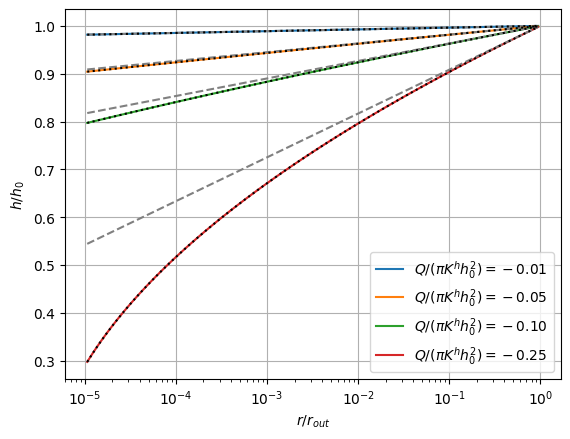

In [10]:
for Q in Qs:
    h = dupuit(r=r, r_out=1, K=1, h0=1, Q=-Q)  # h/h0 according to Dupuit (1857, 1863) formula
    hc = thiem(r=r, r_out=1, T=1, h0=1, Q=-Q)  # h/h0 according to Thiem (1870, 1906) formula
    plt.semilogx(r, h, '-', label=f"$Q/(\pi K^h h_0^2)={-Q:.2f}$");
    plt.semilogx(r, hc, color='gray', linestyle='--');
plt.semilogx(r, np.array(ha).T, 'k:');  # semi-analytical solution
plt.xlabel('$r/r_{out}$');
plt.ylabel('$h/h_0$');
plt.legend();
plt.grid();

### Three-layer example

Example Section 8.2.4.2 (Figure 3):

In [35]:
D = np.array([[50, 50, 50]]).T                 # thickness (m)
K = np.array([[4, 2, 5]]).T                    # horizontal conductivity (m/d)
S = np.array([[0.2, 0.005, 0.001]]).T          # storativity (-)
c = np.array([[np.inf, 100, 500, np.inf]]).T   # vertical resistance (d)
Q = np.array([-2500, 0, -1250])                # pumping rate (m³/d)

rb = np.logspace(-1, 3, 51)     # zone/ring boundaries
r = np.sqrt(rb[1:] * rb[:-1])   # radial distances (m)
nr = len(r)                     # number of rings/distances

Steady-state model:

In [36]:
# steady + confined:
conf = Steady(R=rb,
              T=np.tile(K*D, (1, nr)),
              c=np.tile(c, (1, nr)),
              h0=np.tile(D, (1, nr)),
              Q=Q)

In [37]:
# steady + unconfined:

h_tmp = np.tile(D, (1, nr))  # initial heads (m)
dh = np.inf
i = 0
while dh > 1e-8 and i < 100:
    unconf = Steady(R=rb,
                    T=np.tile(K, (1, nr)) * h_tmp,
                    c=np.tile(c, (1, nr)),
                    h0=50*np.ones((5, nr)),
                    Q=Q)
    h_tmp, h_old = unconf.h(r=r), h_tmp
    h_tmp[1:, :] = D[1:]
    dh = np.sum(np.abs(h_tmp[0, :] - h_old[0, :]))
    i += 1
    print(i, dh)

1 380.9554391936803
2 47.596645937445466
3 6.077474662338901
4 0.6537428326183203
5 0.05843960482777533
6 0.004435841770824567
7 0.0002922926414150595
8 1.7013503697427268e-05
9 8.865685110492905e-07
10 4.1794351091084536e-08
11 1.7959855824756232e-09


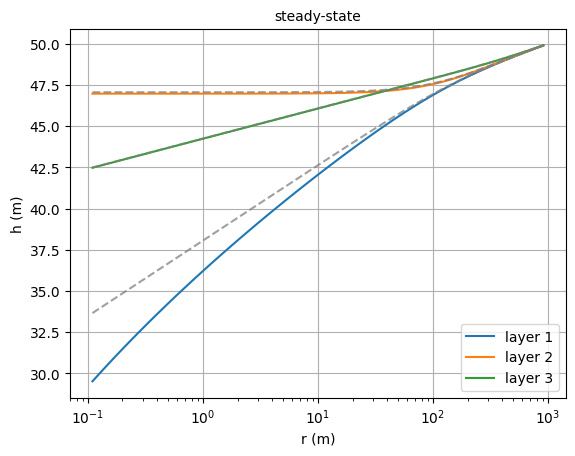

In [38]:
# plot of steady-state confined vs unconfined:
plt.semilogx(r, unconf.h(r).T);
plt.legend([f'layer {i}' for i in range(1, 4)]);
plt.semilogx(r, conf.h(r).T, color="gray", linestyle='--', alpha=0.75);
plt.grid();
plt.xlabel('r (m)');
plt.ylabel('h (m)');
plt.title('steady-state', dict(fontsize=10));

Transient-state model:

In [30]:
# transient + confined
conf = Transient(R=[0, np.inf],
                 T=K*D,
                 S=S,
                 c=c,
                 h0=D,
                 Q=Q,
                 ns=8)

In [32]:
# transient + unconfined: h vs r

t = 1e5  # time (d)
rb = np.logspace(-1, 7, 151)  # zone/ring boundaries
r = np.sqrt(rb[:-1] * rb[1:])  # radial distances (m)
r = np.hstack((r, rb[-1]))
nr = len(r)
h_tmp = np.tile(D, (1, nr))  # initial head (m)
dh = np.inf
i = 0
ncheck = 20
while dh > 1e-6 and i < 20:
    unconf = Transient(R=np.hstack((rb, np.inf)),
                       T=np.tile(K, (1, nr)) * h_tmp,
                       S=np.tile(S, (1, nr)),
                       c=np.tile(c, (1, nr)),
                       h0=50*np.ones((5, nr)),
                       Q=Q,
                       ns=8)
    h_tmp, h_old = unconf.h(r=r, t=[t])[:, :, 0], h_tmp
    h_tmp[1:, :] = D[1:]
    dh = np.sum(np.abs(h_tmp[0, :ncheck] - h_old[0, :ncheck]))
    i += 1
    print(i, dh)

1 351.1558675858935
2 76.87725573524725
3 16.29380711247269
4 2.7508165212510427
5 0.3684282793683309
6 0.04059494108811279
7 0.0038088111003133918
8 0.00031269687423929327
9 2.234439765302909e-05
10 1.3373251022130717e-06
11 1.3921927788373978e-07


In [ ]:
# transient + unconfined: h vs t

t_series =  np.logspace(-5, 5, 50)  # simulation times (d)
rw = 0.1  # well-radius (m) = distance of observations
ncheck = 20
models = []
h_tmp = np.tile(D, (1, nr))  # initial heads (m)
for k, t in enumerate(t_series):
    print('-------------------')
    print(k, '-', t)
    dh = np.inf
    i = 0
    while dh > 1e-7 and i < 20:
        m = Transient(R=np.hstack((rb, np.inf)),
                      T=np.tile(K, (1, nr)) * h_tmp,
                      S=np.tile(S, (1, nr)),
                      c=np.tile(c, (1, nr)),
                      h0=np.tile(D, (1, nr)),
                      Q=Q,
                      ns=8)
        h_tmp, h_old = m.h(r=r, t=[t])[:, :, 0], h_tmp
        h_tmp[1:, :] = D[1:]
        dh = np.sum(np.abs(h_tmp[0, :ncheck] - h_old[0, :ncheck]))
        i += 1
        print(i, dh)
    models.append(m)

# finally we are able to simulate h vs t using the created models for each simulation time t
h = np.array([model.h(r=[rw], t=[t])[:, 0, 0] for t, model in zip(t_series, models)])

Creating Figure 3:

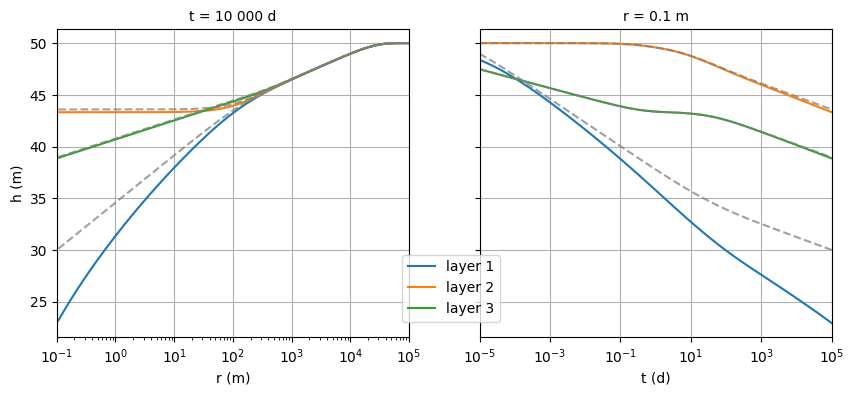

In [34]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

ax1.semilogx(r, unconf.h(r, [t]).squeeze().T, '-');
ax1.semilogx(r, conf.h(r, [t]).squeeze().T, color='gray', linestyle='--', alpha=0.75);
ax1.set_xlim((1e-1, 1e5));
ax1.set_xlabel('r (m)');
ax1.set_ylabel('h (m)');
ax1.set_title('t = 10 000 d', dict(fontsize=10));
ax1.grid();

ax2.semilogx(t_series, h, '-');
ax2.semilogx(t_series, conf.h(r=[0.1], t=t_series)[:, 0, :].T, color='gray', linestyle='--', alpha=0.75);
ax2.legend(['layer ' + str(i+1) for i in range(3)], loc=(-0.22, 0.05));
ax2.set_xlim((1e-5, 1e5));
ax2.set_xlabel('t (d)');
ax2.set_title('r = 0.1 m', dict(fontsize=10));
ax2.grid();

## Delayed yield

### Boulton model

Dimensionless parameter example (Section 8.3.4.1, Figure 5):

In [ ]:
# input
T = 1;
c = 1;
Sy = 1;
Q = 1;
r = np.logspace(-5,0,6);  # r/sqrt(T*c)
t = np.logspace(-5, 5, 100);  # t/Sy/c
S_range = [0.001, 0.1];  # S/Sy

In [46]:
# Hemker (1999) solution defining a dummy layer for the delayed yield

s = []  # s*T/Q
for i, S in enumerate(S_range):
    m = Transient(R=[0, np.inf], T=[[1e-7],[T]], S=[[Sy],[S]], c=[[np.inf],[c],[np.inf]], Q=[0, Q])
    s.append(m.h(r=r, t=t))

In [47]:
# solution that explicitly defines delayed yield as upper boundary condition (Louwyck, 2023)

sb = []  # s*T/Q
for i, S in enumerate(S_range):
    m = TransientBoulton(R=[0, np.inf], T=[T], S=[S], Sy=Sy, c=[c,np.inf], Q=[Q])
    sb.append(m.h(r=r, t=t))

In [50]:
# corresponding theis (1935) solution considering specific yield as storage coefficient
s_theis = theis(r=r, t=t, S=Sy, T=T, Q=Q)

Creating Figure 5:

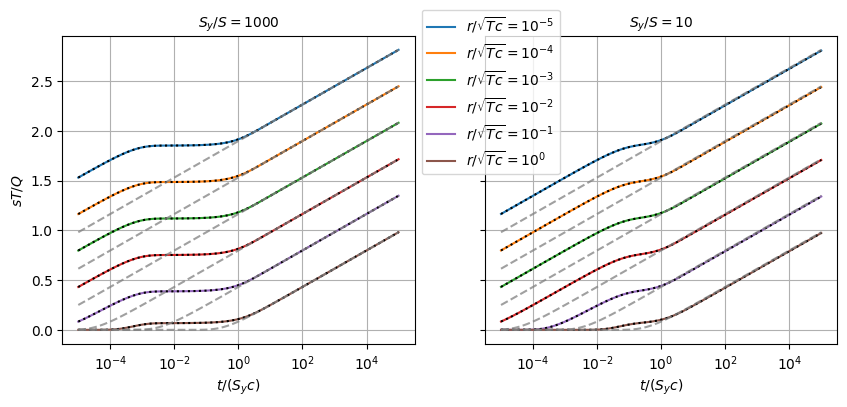

In [53]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
ax1.semilogx(t, s[0][-1,:,:].T, '-');
ax1.semilogx(t, sb[0][-1,:,:].T, 'k:');
ax1.semilogx(t, s_theis.T, color='gray', linestyle='--', alpha=0.75)
ax1.grid();
ax1.set_xlabel('$t/(S_yc)$')
ax1.set_ylabel('$sT/Q$')
ax1.set_title('$S_y/S = 1000$', fontdict=dict(fontsize=10));

ax2.semilogx(t, s[1][-1,:,:].T, '-');
ax2.legend(['$r/\sqrt{Tc} = 10^{' + str(int(np.log10(r))) + '}$' for r in r], loc=(-0.18, 0.55));
ax2.semilogx(t, sb[1][-1,:,:].T, 'k:');
ax2.semilogx(t, s_theis.T, color='gray', linestyle='--', alpha=0.75)
ax2.grid();
ax2.set_xlabel('$t/(S_yc)$')
ax2.set_title('$S_y/S = 10$', fontdict=dict(fontsize=10));

Note that the analytical solution by Boulton (1954, 1963) is omitted here. The improper integral occurring in this solution must be solved numerically, for instance, using the vectorized adaptive quadrature implemented in Matlab function "quadgk" (Shampine, 2008). See Louwyck (2011) for an example.

### Three-layer example

Example Section 8.3.4.2 (Figure 6):

In [104]:
# input

D = np.array([[1, 50, 50, 50]]).T                # layer thickness (m)
K = np.array([[1e-5, 4, 2, 5]]).T                # horizontal conductivity (m/d)
S = np.array([[0.2, 0.005, 0.005, 0.001]]).T     # storativity (-)
c = np.array([[np.inf, 1, 100, 500, np.inf]]).T  # vertical resistance (d)
Q = np.array([0, -2500, 0, -1250])               # pumping rate (m³/d)

r = np.logspace(-1, 5, 151)  # radial distances (m)
t =  np.logspace(-5, 5, 50)  # simulation times (d)

In [105]:
# Hemker (1999) solution defining a dummy layer for the delayed yield
m = Transient(R=[0, np.inf],
              T=K * D,
              S=S,
              c=c,
              h0=D[1]*np.ones((len(D)+2, 1)),
              Q=Q,
              ns=8)

In [106]:
# solution that explicitly defines delayed yield as upper boundary condition (Louwyck, 2023)
mb = TransientBoulton(R=[0, np.inf],
                      T=(K * D)[1:].squeeze(),
                      S=S[1:].squeeze(),
                      Sy=S[0, 0],  # specific yield
                      c=c[1:].squeeze(),
                      h_out=D[1]*np.ones((len(D)+1, )),
                      Q=Q[1:],
                      ns=8)

In [107]:
# corresponding confined model without delayed yield (Hemker, 1999)
conf = Transient(R=[0, np.inf],
                 T=(K * D)[1:],
                 S=S[[0, 2, 3]],
                 c=c[[0, 2, 3, 4]],
                 h0=D[1:],
                 Q=Q[1:],
                 ns=8)

Creating Figure 6:

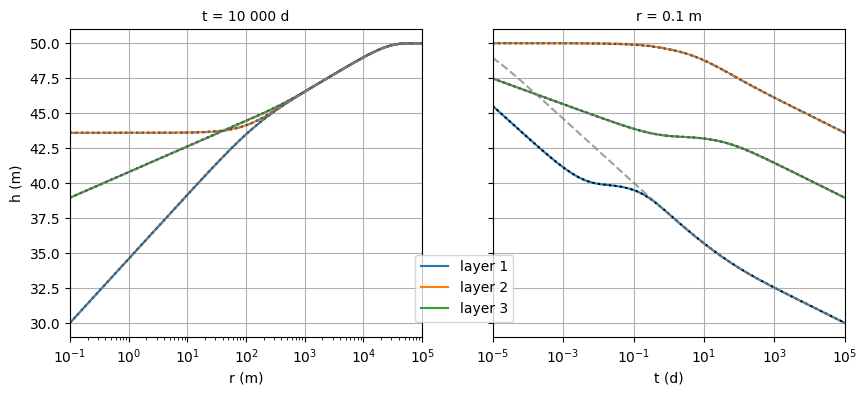

In [108]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

ax1.semilogx(r, m.h(r, t[[-1]])[1:, :, 0].T, '-');
ax1.semilogx(r, mb.h(r, t[[-1]])[:, :, 0].T, 'k:');
ax1.semilogx(r, conf.h(r, t[[-1]]).squeeze().T, color='gray', linestyle='--', alpha=0.75);
ax1.set_xlim((1e-1, 1e5));
ax1.set_xlabel('r (m)');
ax1.set_ylabel('h (m)');
ax1.set_title('t = 10 000 d', dict(fontsize=10));
ax1.grid();

ax2.semilogx(t, m.h(r=r[[0]], t=t)[1:, 0, :].T, '-');
ax2.semilogx(t, mb.h(r=r[[0]], t=t)[:, 0, :].T, 'k:');
ax2.semilogx(t, conf.h(r=r[[0]], t=t)[:, 0, :].T, color='gray', linestyle='--', alpha=0.75);
ax2.legend(['layer ' + str(i+1) for i in range(3)], loc=(-0.22, 0.05));
ax2.set_xlim((1e-5, 1e5));
ax2.set_xlabel('t (d)');
ax2.set_title('r = 0.1 m', dict(fontsize=10));
ax2.grid();

## References

- Boulton, N. S. (1954a). Unsteady radial flow to a pumped well allowing for delayed yield from storage. General Assembly of Rome, Tome II, Groundwater, IAHS publ. 37, 472–477.

- Boulton, N. S. (1954b). The drawdown of the watertable under non-steady conditions near a pumped well in an unconfined formation. Proceedings of the Institution of Civil Engineers, 3(4), 564–579. https://doi.org/10.1680/ipeds.1954.12586

- Boulton, N. S. (1963). Analysis of data from non-equilibrium pumping tests allowing for delayed yield from storage. Proceedings of the Institution of Civil Engineers, 26(3), 469–482. https://doi.org/10.1680/iicep.1963.10409

- Dupuit, J. (1857). Mouvement de l’eau à travers les terrains perméables (in French). Comptes Rendus de l’Académie Des Sciences, 45, 92–96.

- Dupuit, J. (1863). Etude Théoriques et Pratiques Sur le Mouvement Des Eaux Dans Les Canaux Découverts et à Travers Les Terrains Perméables (in French). Paris: Dunot.

- Hemker, C. J. (1999). Transient well flow in vertically heterogeneous aquifers. Journal of Hydrology, 225(1–2), 1–18. https://doi.org/10.1016/S0022-1694(99)00137-7

- Louwyck, A. (2011). MAxSym - A MATLAB Tool to Simulate Two-Dimensional Axi-Symmetric Groundwater Flow. Research Unit Groundwater Modeling, Ghent University. Retrieved from https://github.com/alouwyck/MAxSym

- Louwyck, A. (2023). Axisymmetric Flow in Multilayer Aquifer Systems: Solutions and Theoretical Considerations. PhD thesis, Laboratory for Applied Geology and Hydrogeology, Department of Geology, Ghent University, Belgium.

- Louwyck, A., Vandenbohede, A., Bakker, M., & Lebbe, L. C. (2012). Simulation of axi-symmetric flow towards wells: A finite-difference approach. Computers & Geosciences, 44, 136–145. https://doi.org/10.1016/j.cageo.2011.09.004

- Stehfest, H. (1970). Algorithm 368: Numerical inversion of Laplace transforms [D5]. Communications of the ACM, 13(1), 47–49. https://doi.org/10.1145/361953.361969

- Theis, C. V. (1935). The relation between the lowering of the Piezometric surface and the rate and duration of discharge of a well using ground-water storage. Transactions, American Geophysical Union, 16(2), 519–524. https://doi.org/10.1029/TR016i002p00519

- Thiem, A. (1870). Die Ergiebigkeit artesischer Bohrlöcher, Schachtbrunnen und Filtergalerien (in German). Journal Für Gasbeleuchtung Und Wasserversorgung, 13, 450–467.

- Thiem, G. (1906). Hydrologische Methoden (in German). Leipzig: Gebhardt.

---